# Import libraries

In [12]:
import os
from os import path, getcwd, chdir
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

print(tf.__version__)

2.7.0


In [13]:
def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("time")
  plt.ylabel("value")
  plt.grid(True)

# Data
## Open and reshape raw datasets

In [14]:
file_path = '/content/drive/MyDrive/motion_dataset/'
train_path = file_path + 'train_dataset/'

In [15]:
dataset = np.loadtxt(train_path+'dataset_withlabels.txt')
print(dataset.shape)

(3718058, 7)


In [5]:
dataset.shape[0]

3718058

In [16]:
# drop some values from dataset to reshape them properly by using indexing
org_size = dataset.shape[0]
new_size = 200
reshape_dataset = dataset[(org_size%new_size):, :].reshape((-1,200,7)) #뒤에서 데이터를 자르면 앉기 데이터가 상당 부분 소실되어서, 앞에서 crop함. 
print(reshape_dataset.shape)

(18590, 200, 7)


## Spliting Train set & Test Set 



In [17]:
# using sklearn.model_selection
trainx, testx, trainy, testy = train_test_split(reshape_dataset[:,:,0:6], # x 0~5
                                                reshape_dataset[:,:,6], # y 6
                                                test_size=0.3,
                                                shuffle = True,
                                                random_state = 1004)

print('trainx shape:', trainx.shape)
print('testx shape:', testx.shape)
print('trainy shape:', trainy.shape)
print('testy shape:', testy.shape)

trainx shape: (13013, 200, 6)
testx shape: (5577, 200, 6)
trainy shape: (13013, 200)
testy shape: (5577, 200)


In [18]:
# reshape trainy and testy from (n, 200) to (n, 1) = indexing and .reshape((n,1)).astype(int)
# to remain the only label per one motion (200*5)
trainy = trainy[:, 0].reshape((trainy.shape[0],1)).astype(int)
testy = testy[:, 0].reshape((testy.shape[0],1)).astype(int)
print('trainy shape:', trainy.shape)
print('testy shape:', testy.shape)
print(trainy)
print(testy)

# change the label value 1,2,3,4 -> 0,1,2,3

trainy = trainy -1
testy = testy - 1
# check again the unique values in testy and trainy set
print(np.unique(trainy))
print(np.unique(testy))

trainy shape: (13013, 1)
testy shape: (5577, 1)
[[1]
 [1]
 [3]
 ...
 [3]
 [1]
 [3]]
[[1]
 [1]
 [1]
 ...
 [2]
 [2]
 [1]]
[0 1 2 3]
[0 1 2 3]


In [9]:
# trainy = to_categorical(trainy, 4)
# testy = to_categorical(testy, 4)

# Model

In [19]:
def train_motion(trainx, trainy, testx, testy):

  class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('acc') > 0.980:
        print("\nReached 98.0% accuracy so canceling training.")
        self.model.stop_training = True
 
  callbacks = myCallback()

  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(units = 100, input_shape = (200,6), return_sequences = False),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(4, activation = 'softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics =['acc'])
  history = model.fit(trainx, trainy,
                      validation_data = (testx, testy),
                      epochs = 20,
                      callbacks=[callbacks])
  
  acc = history.history['acc']
  loss = history.history['loss']
  val_acc = history.history['val_acc']
  val_loss = history.history['val_loss']
  # history.epoch, history.history['acc'][-1]
  return model

In [20]:
#model1 = train_motion(trainx, trainy, testx, testy)
model2 = train_motion(trainx, trainy, testx, testy)

Epoch 1/20
407/407 [==============================] - 25s 55ms/step - loss: 0.4064 - acc: 0.9033 - val_loss: 0.1331 - val_acc: 0.9674
Epoch 2/20
407/407 [==============================] - 22s 54ms/step - loss: 0.1416 - acc: 0.9620 - val_loss: 0.1287 - val_acc: 0.9638
Epoch 3/20
407/407 [==============================] - 23s 57ms/step - loss: 0.1257 - acc: 0.9632 - val_loss: 0.1503 - val_acc: 0.9571
Epoch 4/20
407/407 [==============================] - 24s 58ms/step - loss: 0.1160 - acc: 0.9669 - val_loss: 0.0996 - val_acc: 0.9729
Epoch 5/20
407/407 [==============================] - 25s 62ms/step - loss: 0.1023 - acc: 0.9683 - val_loss: 0.0951 - val_acc: 0.9744
Epoch 6/20
407/407 [==============================] - 26s 63ms/step - loss: 0.1009 - acc: 0.9699 - val_loss: 0.0869 - val_acc: 0.9776
Epoch 7/20
407/407 [==============================] - 23s 56ms/step - loss: 0.0877 - acc: 0.9727 - val_loss: 0.0940 - val_acc: 0.9753
Epoch 8/20
407/407 [==============================] - 22s 53ms

In [ ]:
model2.summary()

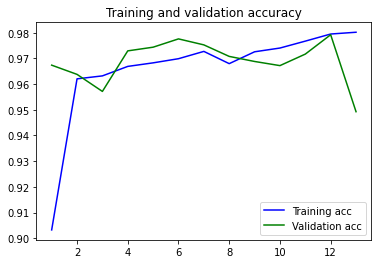

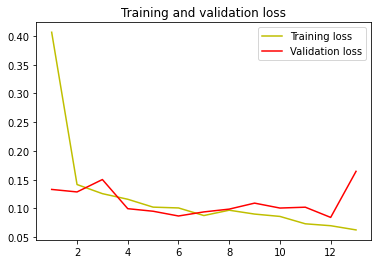

In [23]:
acc = model2.history.history['acc']
loss = model2.history.history['loss']
val_acc = model2.history.history['val_acc']
val_loss = model2.history.history['val_loss']

# 학습과정 시각화
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# validation test


In [22]:
# 모델 전체 저장하기
model2.save('motion_model2.h5')
# 모델 불러오기
# new_model = keras.models.load_model('motion_model2.h5')
# new_model.summary()

In [ ]:
# Running the model
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  #predicting motions
  path = '/content/' + fn
  motion_data = np.genfromtxt(path)
  motion_data = motion_data[:,-6:]

  org_size = motion_data.shape[0]
  new_size = 200
  cleaned_motion_data = motion_data[:org_size-(org_size%new_size),:].reshape((-1,200,6))
  
  y_prob = model2.predict(cleaned_motion_data)
  predicted = y_prob.argmax(axis = -1)

  print(f"{fn}:", predicted)